In [1]:
import os
import re
import glob
import yaml

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import animation
import matplotlib.cm as cm

import napari

from utils.utility_functions import single_channel_pyramid

In [2]:
def rotation_movie(main, azim_init, num_frames):
    
    fig = plt.figure(figsize=(14.5, 10))
    ax = plt.axes(projection='3d', computed_zorder=False)
    
    g = ax.scatter(
            main['VAE9_VIG7_emb1'], main['VAE9_VIG7_emb2'], main['VAE9_VIG7_emb3'],
            c=main['FOXP3_570'], cmap='viridis', s=150000/len(main), ec='k', linewidth=0.0
        )
    
    cbar = fig.colorbar(g, ax=ax, shrink=0.35, aspect=11, pad=0.03)
    cbar.set_label('FOXP3', fontsize=11)
    cbar.ax.tick_params(labelsize=9)
        
    plt.tight_layout()

    def init():

        ax.axis('auto')
        ax.grid(True)
        ax.grid(True)
        ax.set_xlabel('UMAP1')
        ax.set_ylabel('UMAP2')
        ax.set_zlabel('UMAP3')

        return fig,

    def animate(i, num_frames, azim_init):
        
        i = i * 360/num_frames
        
        if i % 10 == 0:
            print(f'degree = {i}')
        ax.view_init(elev=10.0, azim=(i + azim_init))
        
        return fig,

    anim = animation.FuncAnimation(
        fig, lambda i: animate(i, num_frames, azim_init), init_func=init,
        frames=num_frames, interval=20, blit=True)
    
    filename = 'V4_FOXP3.mp4'
    anim.save(
        os.path.join(out, filename),
        dpi=200, fps=30, extra_args=['-vcodec', 'libx264'])

In [3]:
# I/O

# read image patch dataframe
main = pd.read_csv(os.path.join(os.getcwd(), 'input/main.csv'))
# data = main.sample(frac=1.0)

# import Leiden-clustered single-cell data
df = pd.read_parquet(
    os.path.join(os.getcwd(), 'input/CRC-097_clean_cylinter_clustering_3d_leiden.parquet')
)

# read OME-TIFF, segmentation outlines, and H&E channels
sample = 'CRC-097' 
tif_path = os.path.join(os.getcwd(), f'input/{sample}_image.ome.tif')
seg_path = os.path.join(os.getcwd(), f'input/{sample}_seg_outlines.ome.tif')
he_path = os.path.join(os.getcwd(), f'input/{sample}_hema_eosin.ome.tif')

# import markers.csv
markers = pd.read_csv(os.path.join(os.getcwd(), 'input/CRC-097_mcmicro_markers.csv'))

# get markers excluded from analysis
with open(os.path.join(os.getcwd(), 'input/CRC-97_cylinter_config.yml')) as f:
    config = yaml.safe_load(f)
markers_to_exclude = config['markersToExclude']

# import image contrast settings
with open(os.path.join(os.getcwd(), 'input/CRC-097_cylinter_contrast_limits.yml')) as f:
    contrast_limits = yaml.safe_load(f)

# isolate antibodies of interest
abx_channels = [
    i for i in df.columns if 'nucleiRingMask' in i
    if 'Hoechst' not in i if i not in markers_to_exclude
]

# get name of first DNA channel
dna1 = markers['marker_name'][markers['channel_number'] == 1][0]
dna_moniker = str(re.search(r'[^\W\d]+', dna1).group())

# out dir
out = os.path.join(os.getcwd(), f'output/treg')
if not os.path.exists(out):
    os.makedirs(out)

VAE4 colored by Seg 13 (blue) and Seg 15 (orange)


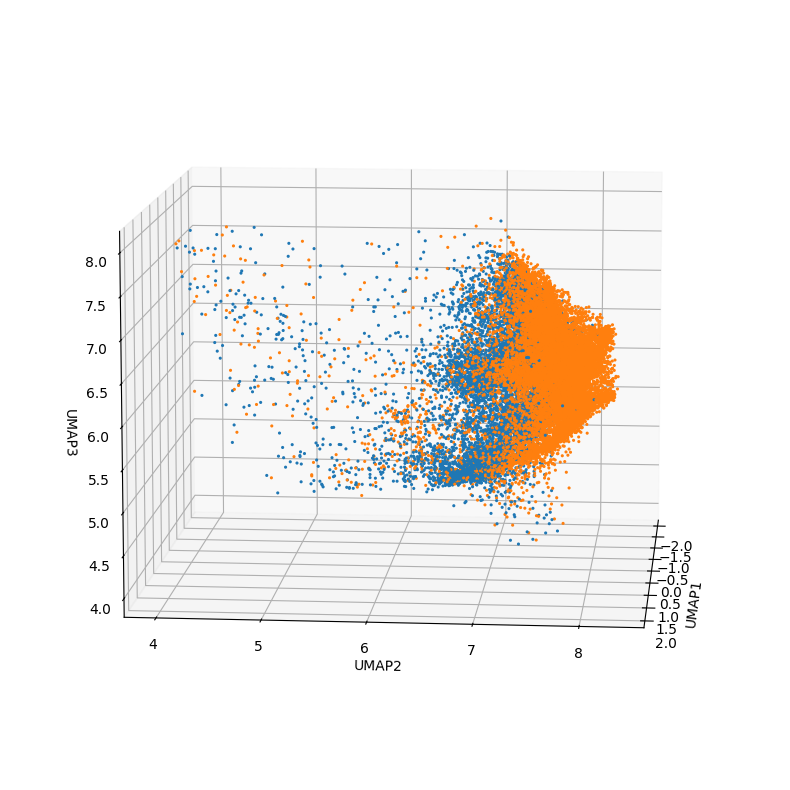

VAE4 colored by FOXP3


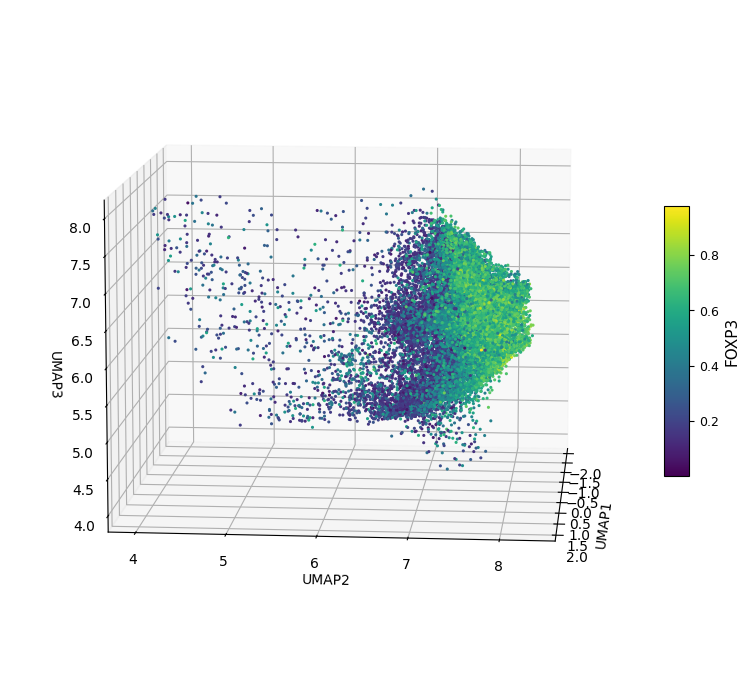

In [4]:
# isolate Tcon/Treg cells from VAE9 clustering and plot
vae = main[main['VAE9_VIG7'] == 4].copy()
vae = vae[vae['Seg'].isin([13, 15])]
vae = vae[(vae['VAE9_VIG7_emb1'] > -2.0) & (vae['VAE9_VIG7_emb1'] < 2.0)]
vae = vae[(vae['VAE9_VIG7_emb2'] > 4.0) & (vae['VAE9_VIG7_emb2'] < 9.0)]
vae = vae[(vae['VAE9_VIG7_emb3'] > 4.0) & (vae['VAE9_VIG7_emb3'] < 8.0)]

vae['color'] = [
    'tab:blue' if val == 13 
    else 'tab:orange' for val in vae['Seg'] 
]

print('VAE4 colored by Seg 13 (blue) and Seg 15 (orange)')
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d', computed_zorder=False) 
ax.view_init(elev=10, azim=5)

ax.scatter(
    vae['VAE9_VIG7_emb1'], vae['VAE9_VIG7_emb2'], vae['VAE9_VIG7_emb3'],
    color=vae['color'], linewidth=0.0, s=5, alpha=1.0,
)

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
ax.axis('auto')
ax.tick_params(labelsize=10)
ax.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(out, 'V4_by_S13_S15.png'), dpi=800)
plt.show()
plt.close('all')

print('VAE4 colored by FOXP3')
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d', computed_zorder=False) 
ax.view_init(elev=10, azim=5)

g = ax.scatter(
    vae['VAE9_VIG7_emb1'], vae['VAE9_VIG7_emb2'], vae['VAE9_VIG7_emb3'],
    c=vae['FOXP3_570'], cmap='viridis', linewidth=0.0, s=5, alpha=1
)

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
ax.axis('auto')
ax.tick_params(labelsize=10)
ax.grid(True)

cbar = fig.colorbar(g, ax=ax, shrink=0.35, aspect=11, pad=-0.01)
cbar.set_label('FOXP3', fontsize=11)
cbar.ax.tick_params(labelsize=9)

plt.tight_layout()
plt.savefig(os.path.join(out, 'V4_FOXP3.png'), dpi=800)
plt.show()
plt.close('all')

In [5]:
# generate and save V4 FOXP3 animation
if not os.path.exists(os.path.join(out, 'V4_FOXP3.mp4')):
    print(f'Saving rotating plot for UMAP region showing V4 cells colored by FOXP3 expression...')
    rotation_movie(main=vae, azim_init=0, num_frames=360)
    print()

Seg13 and Seg 15 colored by Seg 15 (orange) and which cells in Seg 13 overlap (green) or not (blue) with V15


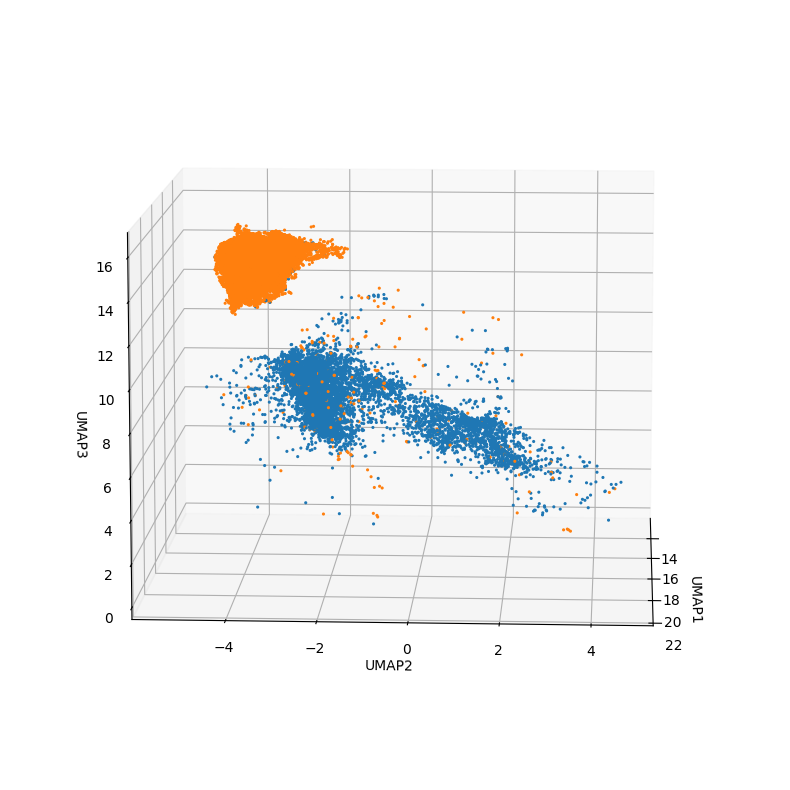

Seg 13 and 15 colored by FOXP3


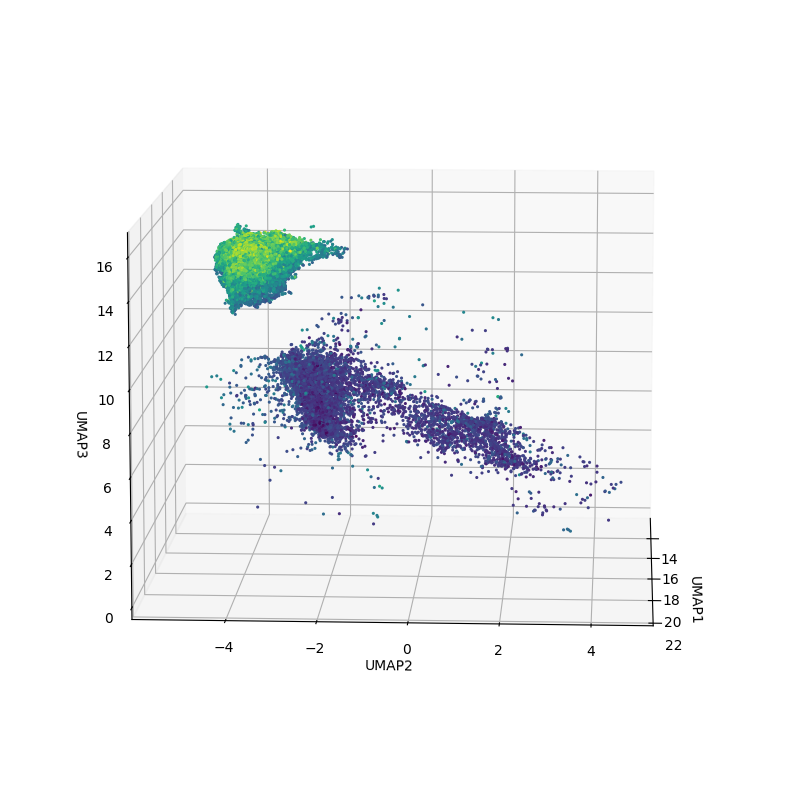

In [8]:
# isolate Tcon/Treg cells from Seg clustering and plot
seg = main[main['Seg'].isin([13, 15])].copy()
seg = seg[seg['VAE9_VIG7'].isin([4])]
seg = seg[(seg['Seg_emb1'] > 10.0) & (seg['Seg_emb1'] < 23.0)]
seg = seg[(seg['Seg_emb2'] > -6.0) & (seg['Seg_emb2'] < 5.0)]
seg = seg[(seg['Seg_emb3'] > 0.0) & (seg['Seg_emb3'] < 16.0)]

print('Seg13 and Seg 15 colored by Seg 15 (orange) and which cells in Seg 13 ' 
      'overlap (green) or not (blue) with V15')

seg['color'] = ['tab:blue' if i == 13 else 'tab:orange'for i in seg['Seg']]

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d', computed_zorder=False) 
ax.view_init(elev=10, azim=3)

ax.scatter(
    seg['Seg_emb1'], seg['Seg_emb2'], seg['Seg_emb3'],
    color=seg['color'], linewidth=0.0, s=5, alpha=1
)

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
ax.axis('auto')
ax.tick_params(labelsize=10)
ax.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(out, 'S13_15.png'), dpi=800)
plt.show()
plt.close('all')

print('Seg 13 and 15 colored by FOXP3')
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d', computed_zorder=False) 
ax.view_init(elev=10, azim=3)
ax.scatter(
    seg['Seg_emb1'], seg['Seg_emb2'], seg['Seg_emb3'],
    c=seg['FOXP3_570'], cmap='viridis', linewidth=0.0, s=5, alpha=1
)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
ax.axis('auto')
ax.tick_params(labelsize=10)
ax.grid(True)

plt.tight_layout() 
plt.savefig(os.path.join(out, 'S13_S15_FOXP3.png'), dpi=800)
plt.show()
plt.close('all')

In [ ]:
gate = 0.3

print('S13 and S15 FOXP3 distributions')
fig, ax = plt.subplots()
# for cluster, label, color in zip([13, 15], ['Seg13', 'Seg15'], ['tab:blue', 'tab:orange']):
#     ax.hist(main['FOXP3_570'][main['Seg'] == cluster], bins=120, color=color, label=label)

ax.hist(main['FOXP3_570'][main['Seg'] == 13], bins=120, color='tab:blue', label='S13')
ax.hist(main['FOXP3_570'][main['Seg'] == 15], bins=120, color='tab:orange', label='S15')
ax.hist(
    main['FOXP3_570'][(main['Seg'] == 13) & (main['VAE9_VIG7'] == 15)], 
    bins=120, label='S13-to-V15', color='tab:green')
ax.axvline(x=gate, c='k')
ax.set_xlabel('FOXP3')

plt.legend()

plt.tight_layout() 
plt.savefig(os.path.join(out, 'S13_S15_s13-to-V15_hist.pdf'))
plt.show()
plt.close('all')
print()
###############################################
# print('V4 FOXP3 distribution')

# fig, ax = plt.subplots()
# n, bins, patches = ax.hist(main['FOXP3_570'][main['VAE9_VIG7'] == 4], bins=120, color='gainsboro')
# ax.axvline(x=gate, c='k')
# ax.set_xlabel('FOXP3')

# # mormalize the colors from the chosen gate point to the max bin height
# norm = Normalize(vmin=gate, vmax=np.max(bins))
# cmap = plt.colormaps['viridis'] 
# fixed_color = 'red'  # color for bars below gate

# # color each bar according to its bin edge value
# for i in range(len(patches)):
#     # if the bin is below the start_point, use the fixed color
#     if bins[i] < gate:
#         patches[i].set_facecolor(fixed_color)
#     else:
#         # normalize and apply colormap for bins at or above start_point
#         color_value = norm(bins[i])
#         patches[i].set_facecolor(cmap(color_value))

# # add the colorbar, specifying the axis
# sm = cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])  # required for ScalarMappable to be used in colorbar
# plt.colorbar(sm, ax=ax, label='FOXP3')

# plt.tight_layout() 
# plt.savefig(os.path.join(out, 'V4_FOXP3_hist.pdf'))
# plt.show()
# plt.close('all')
#########################################################
print('V4 colored by S13 (tab:blue) and S15 (viridis')

fig, ax = plt.subplots()
ax.hist(main['FOXP3_570'][(main['VAE9_VIG7'] == 4) & (main['Seg'] == 13)], bins=120, color='tab:blue', label='S13')
n, bins, patches = ax.hist(main['FOXP3_570'][(main['VAE9_VIG7'] == 4) & (main['Seg'] == 15)], bins=120, label='S15')
ax.axvline(x=gate, c='k')
ax.set_xlabel('FOXP3')

# mormalize the colors from the chosen gate point to the max bin height
norm = Normalize(vmin=np.min(bins), vmax=np.max(bins))
cmap = plt.colormaps['magma']
# from matplotlib.colors import LinearSegmentedColormap
# cmap = LinearSegmentedColormap.from_list("custom_orange", ['black', 'tab:orange'])

# color each bar according to its bin edge value
for i in range(len(patches)):
    # normalize and apply colormap for bins at or above start_point
    color_value = norm(bins[i])
    patches[i].set_facecolor(cmap(color_value))

# add the colorbar, specifying the axis
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # required for ScalarMappable to be used in colorbar
plt.colorbar(sm, ax=ax, label='FOXP3')

plt.tight_layout() 
plt.savefig(os.path.join(out, 'V4_FOXP3_hist.pdf'))
plt.show()
plt.close('all')



In [ ]:
# print('V4 CD4 distribution')
# gate = 0.2
# fig, ax = plt.subplots()
# n, bins, patches = ax.hist(main['CD4_488'][main['VAE9_VIG7'] == 4], bins=120, color='gainsboro')
# ax.axvline(x=gate, c='k')

# # mormalize the colors from the chosen gate point to the max bin height
# norm = Normalize(vmin=gate, vmax=np.max(bins))
# cmap = plt.colormaps['viridis'] 
# fixed_color = 'red'  # color for bars below gate

# # color each bar according to its bin edge value
# for i in range(len(patches)):
#     # if the bin is below the start_point, use the fixed color
#     if bins[i] < gate:
#         patches[i].set_facecolor(fixed_color)
#     else:
#         # normalize and apply colormap for bins at or above start_point
#         color_value = norm(bins[i])
#         patches[i].set_facecolor(cmap(color_value))

# # add the colorbar, specifying the axis
# sm = cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])  # required for ScalarMappable to be used in colorbar
# plt.colorbar(sm, ax=ax, label='CD4')

# plt.tight_layout() 
# plt.savefig(os.path.join(out, 'V4_CD4_hist.pdf'))
# plt.show()
# plt.close('all')

s13 = main[(main['Seg'] == 13) & (main['VAE9_VIG7'] == 4)]
s15 = main[(main['Seg'] == 15) & (main['VAE9_VIG7'] == 4)]
plt.scatter(s13['CD4_488'], s13['FOXP3_570'], s=0.5, c='tab:blue')
plt.scatter(s15['CD4_488'], s15['FOXP3_570'], s=0.5, c='tab:orange')
plt.xlabel('CD4')
plt.ylabel('FOXP3')

plt.tight_layout() 
plt.savefig(os.path.join(out, 'CD4_FOXP3_scatter.png'), dpi=800)
plt.show()
plt.close('all')

In [ ]:
# initialize image viewer
viewer = napari.Viewer()

In [ ]:
# add DNA1 channel to image viewer
dna, min, max = single_channel_pyramid(glob.glob(tif_path)[0], channel=0)
viewer.add_image(
    dna, rgb=False, blending='additive', colormap='gray', visible=True, opacity=0.8,
    name='DNA1', contrast_limits=(min, max)
)

In [ ]:
# loop over antibodies of interest, add to image viewer, and apply contrast limits
for ch in abx_channels:
    ch = ch.rsplit('_', 1)[0]
    channel_number = markers['channel_number'][markers['marker_name'] == ch]
    img, min, max = single_channel_pyramid(
        glob.glob(tif_path)[0], channel=(channel_number.item() - 1)
    )
    viewer.add_image(
        img, rgb=False, blending='additive', colormap='green', visible=False,
        name=ch, contrast_limits=(min, max)
    )

for ch in abx_channels:
    ch = ch.rsplit('_', 1)[0]
    viewer.layers[ch].contrast_limits = (
        contrast_limits[ch][0], contrast_limits[ch][1])

In [ ]:
# add centroids to image viewer
s13 = main[(main['VAE9_VIG7'] == 4) & (main['Seg'] == 13)]
s15 = main[(main['VAE9_VIG7'] == 4) & (main['Seg'] == 15)]

centroids1 = s13[['Y_centroid', 'X_centroid']]
viewer.add_points(
    centroids1, name='V4-to-S13', face_color='#1f77b4', border_color='white',
    border_width=0.0, size=60.0, opacity=1.0, blending='opaque', visible=False
)

centroids2 = s15[['Y_centroid', 'X_centroid']]
point_properties1 = {'probability': s15['FOXP3_570']}
viewer.add_points(
    centroids2, name='V4-to-S15', properties=point_properties1,
    face_color='probability', face_colormap='magma',
    border_width=0.0, size=60.0, opacity=1.0, blending='opaque',
    visible=False
)

s13_v15 = main[(main['Seg'] == 13) & (main['VAE9_VIG7'] == 15) & (main['FOXP3_570'] > 0.0)]
centroids3 = s13_v15[['Y_centroid', 'X_centroid']]
point_properties2 = {'probability': s13_v15['FOXP3_570']}
viewer.add_points(
    centroids3, name='S13-to-V15_FOXP3>0.3', properties=point_properties2,
    face_color='probability', face_colormap='magma',
    border_width=0.0, size=60.0, opacity=1.0, blending='opaque',
    visible=False
)

In [ ]:
# add segmentation outlines to image viewer
seg, min, max = single_channel_pyramid(glob.glob(seg_path)[0], channel=0)
viewer.add_image(
    seg, rgb=False, blending='additive', colormap='gray', visible=False,
    name='segmentation', opacity=0.3
)

In [ ]:
# run image viewer
viewer.scale_bar.visible = True
viewer.scale_bar.unit = 'um'

napari.run()